In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandasql
import gc
import multiprocessing
import os,sys
import missingno as msno
import gc

In [2]:
np.random.seed(51)

In [3]:
import lightgbm as lgb

In [4]:
from sklearn.model_selection import StratifiedKFold

In [5]:
import matplotlib.pyplot as plt

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
%%time
train_metadata = pd.read_csv('train_metadata_final.csv')
test_metadata = pd.read_csv('test_metadata_final.csv')

CPU times: user 1min 12s, sys: 4.7 s, total: 1min 17s
Wall time: 1min 17s


In [8]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
"""%%time
train_metadata = reduce_mem_usage(train_metadata)
test_metadata = reduce_mem_usage(test_metadata)"""

'%%time\ntrain_metadata = reduce_mem_usage(train_metadata)\ntest_metadata = reduce_mem_usage(test_metadata)'

In [10]:
gc.collect()

7

In [11]:
galactic_metadata = train_metadata[train_metadata['hostgal_specz'] == 0]
extragalactic_metadata = train_metadata[train_metadata['hostgal_specz'] != 0]

In [12]:
print(galactic_metadata.shape,extragalactic_metadata.shape)

(2325, 145) (5523, 145)


In [13]:
print("number of unique target classes in galactic_metadata is {}".format(len(galactic_metadata['target'].unique())))

number of unique target classes in galactic_metadata is 5


In [14]:
print("number of unique target classes in extragalactic_metadata is {}".format(len(extragalactic_metadata['target'].unique())))

number of unique target classes in extragalactic_metadata is 9


In [15]:
test_metadata['hostgal_specz'].isnull().sum()

3372497

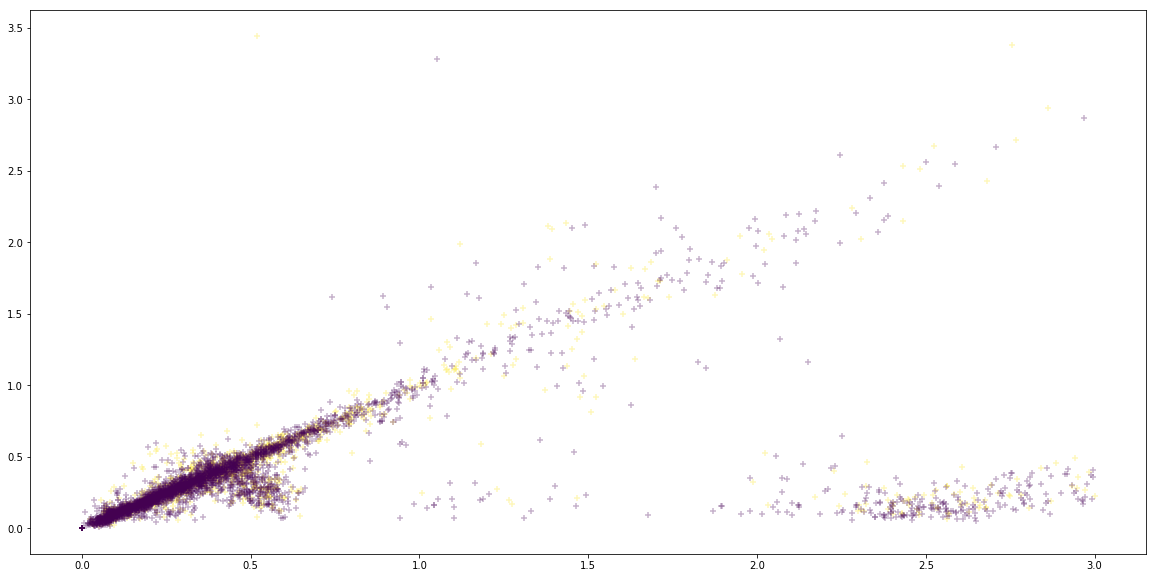

In [16]:
plt.figure(figsize=(20,10))
plt.scatter(x = train_metadata['hostgal_photoz'], 
                y = train_metadata['hostgal_specz'], 
                c = train_metadata['ddf'],alpha = 0.3,marker = '+',)
plt.show()

In [17]:
train_metadata[['hostgal_photoz','hostgal_specz']].corr()

,hostgal_photoz,hostgal_specz
hostgal_photoz,1.000000,0.550371
hostgal_specz,0.550371,1.000000


In [18]:
train_metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,NG_count_flux_err,NG_min_flux_err,NG_max_flux_err,NG_std_flux_err,NG_sum_flux_err,NG_mean_flux_err,NG_median_flux_err,NG_count_flux,NG_min_flux,NG_max_flux,NG_std_flux,NG_sum_flux,NG_mean_flux,NG_median_flux,NG_count_detected,NG_std_detected,NG_sum_detected,NG_mean_detected,NG_median_detected,A0_count_flux_err,A0_min_flux_err,A0_max_flux_err,A0_std_flux_err,A0_sum_flux_err,A0_mean_flux_err,A0_median_flux_err,A0_count_flux,A0_min_flux,A0_max_flux,A0_std_flux,A0_sum_flux,A0_mean_flux,A0_median_flux,A0_count_detected,A0_std_detected,A0_sum_detected,A0_mean_detected,A0_median_detected,A1_count_flux_err,A1_min_flux_err,A1_max_flux_err,A1_std_flux_err,A1_sum_flux_err,A1_mean_flux_err,A1_median_flux_err,A1_count_flux,A1_min_flux,A1_max_flux,A1_std_flux,A1_sum_flux,A1_mean_flux,A1_median_flux,A1_count_detected,A1_std_detected,A1_sum_detected,A1_mean_detected,A1_median_detected,A2_count_flux_err,A2_min_flux_err,A2_max_flux_err,A2_std_flux_err,A2_sum_flux_err,A2_mean_flux_err,A2_median_flux_err,A2_count_flux,A2_min_flux,A2_max_flux,A2_std_flux,A2_sum_flux,A2_mean_flux,A2_median_flux,A2_count_detected,A2_std_detected,A2_sum_detected,A2_mean_detected,A2_median_detected,A3_count_flux_err,A3_min_flux_err,A3_max_flux_err,A3_std_flux_err,A3_sum_flux_err,A3_mean_flux_err,A3_median_flux_err,A3_count_flux,A3_min_flux,A3_max_flux,A3_std_flux,A3_sum_flux,A3_mean_flux,A3_median_flux,A3_count_detected,A3_std_detected,A3_sum_detected,A3_mean_detected,A3_median_detected,A4_count_flux_err,A4_min_flux_err,A4_max_flux_err,A4_std_flux_err,A4_sum_flux_err,A4_mean_flux_err,A4_median_flux_err,A4_count_flux,A4_min_flux,A4_max_flux,A4_std_flux,A4_sum_flux,A4_mean_flux,A4_median_flux,A4_count_detected,A4_std_detected,A4_sum_detected,A4_mean_detected,A4_median_detected,A5_count_flux_err,A5_min_flux_err,A5_max_flux_err,A5_std_flux_err,A5_sum_flux_err,A5_mean_flux_err,A5_median_flux_err,A5_count_flux,A5_min_flux,A5_max_flux,A5_std_flux,A5_sum_flux,A5_mean_flux,A5_median_flux,A5_count_detected,A5_std_detected,A5_sum_detected,A5_mean_detected,A5_median_detected
0,615,349.0000,-61.94,320.8,-51.75,1,0.0000,0.0000,0.0000,NaN,0.017,92,352,2.1300,12.845472,1.744747,1577.92540,4.482743,3.836,352,-1100.440100,660.626340,394.109860,-43330.14500,-123.097000,-89.5000,352,0.2263,333.0,0.9460,1.0,63,2.844200,4.737393,0.493621,240.87724,3.823448,3.866380,63,-116.913220,125.182810,83.944730,-205.03693,-3.254554,-10.015225,63,0.3528,54,0.85700,1.0,58,3.0350,6.953,1.1680,291.682800,5.027,4.980,58,-1100.000,660.626340,601.787300,-22370.596000,-385.8000,-488.0000,58,0.1841,56,0.9653,1.0,58,2.1300,4.332,0.5796,196.00,3.380,3.3890,58,-682.000,611.984560,455.121340,-7780.501000,-134.146560,-265.8000,58,0.1313,57,0.9830,1.0,58,2.5000,4.010,0.3474,193.726720,3.340,3.389,58,-530.500,445.737060,335.425050,-7024.003000,-121.103500,-162.1000,58,0.1313,57,0.9830,1.0,58,2.900,11.400,1.0890,220.328110,3.799,3.625,58,-422.184500,381.953740,291.803440,-3245.366500,-55.954594,-103.541370,58,0.1313,57,0.9830,1.0,57,6.074,12.84,1.3180,435.25317,7.637,7.310,57,-422.815100,378.188140,294.779500,-2704.64140,-47.449850,-85.524310,57,0.2854,52,0.9120,1.0
1,713,53.1000,-27.78,223.5,-54.47,1,1.8180,1.6270,0.2551,45.40,0.007,88,350,0.6396,9.115748,1.509888,825.86700,2.359620,1.998,350,-14.735178,14.770886,6.471144,-498.17276,-1.423351,-0.8730,350,0.3774,60.0,0.1714,0.0,70,1.470152,3.348282,0.411563,163.19803,2.331400,2.273303,70,-14.735178,14.509829,7.113509,-190.42786,-2.720398,-3.096805,70,0.3525,10,0.14280,0.0,56,0.7070,3.545,0.7070,79.351020,1.417,1.115,56,-11.720,9.129021,5.712334,-57.109047,-1.0200,-0.5615,56,0.4468,15,0.2678,0.0,56,0.6396,2.531,0.4397,66.80,1.193,1.0625,56,-10.070,10.529041,5.770738,-44.477325,-0.794238,-0.1180,56,0.4468,15,0.2678,0.0,56,0.9683,2.970,0.4270,91.848694,1.641,1.630,56,-12.400,11.330316,6.450413,-55.270115,-0.986966,-0.0739,56,0.4468,15,0.2678,0.0,56,1.430,3.555,0.5015,

In [19]:
def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')
    
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

In [20]:
def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

In [21]:
gc.enable()
gc.collect()

2348

In [22]:
y = train_metadata['target']

In [23]:
del train_metadata['target']

In [24]:
classes = sorted(y.unique())

In [25]:
classes

[6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]

In [26]:
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

In [27]:
train_metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,NG_count_flux_err,NG_min_flux_err,NG_max_flux_err,NG_std_flux_err,NG_sum_flux_err,NG_mean_flux_err,NG_median_flux_err,NG_count_flux,NG_min_flux,NG_max_flux,NG_std_flux,NG_sum_flux,NG_mean_flux,NG_median_flux,NG_count_detected,NG_std_detected,NG_sum_detected,NG_mean_detected,NG_median_detected,A0_count_flux_err,A0_min_flux_err,A0_max_flux_err,A0_std_flux_err,A0_sum_flux_err,A0_mean_flux_err,A0_median_flux_err,A0_count_flux,A0_min_flux,A0_max_flux,A0_std_flux,A0_sum_flux,A0_mean_flux,A0_median_flux,A0_count_detected,A0_std_detected,A0_sum_detected,A0_mean_detected,A0_median_detected,A1_count_flux_err,A1_min_flux_err,A1_max_flux_err,A1_std_flux_err,A1_sum_flux_err,A1_mean_flux_err,A1_median_flux_err,A1_count_flux,A1_min_flux,A1_max_flux,A1_std_flux,A1_sum_flux,A1_mean_flux,A1_median_flux,A1_count_detected,A1_std_detected,A1_sum_detected,A1_mean_detected,A1_median_detected,A2_count_flux_err,A2_min_flux_err,A2_max_flux_err,A2_std_flux_err,A2_sum_flux_err,A2_mean_flux_err,A2_median_flux_err,A2_count_flux,A2_min_flux,A2_max_flux,A2_std_flux,A2_sum_flux,A2_mean_flux,A2_median_flux,A2_count_detected,A2_std_detected,A2_sum_detected,A2_mean_detected,A2_median_detected,A3_count_flux_err,A3_min_flux_err,A3_max_flux_err,A3_std_flux_err,A3_sum_flux_err,A3_mean_flux_err,A3_median_flux_err,A3_count_flux,A3_min_flux,A3_max_flux,A3_std_flux,A3_sum_flux,A3_mean_flux,A3_median_flux,A3_count_detected,A3_std_detected,A3_sum_detected,A3_mean_detected,A3_median_detected,A4_count_flux_err,A4_min_flux_err,A4_max_flux_err,A4_std_flux_err,A4_sum_flux_err,A4_mean_flux_err,A4_median_flux_err,A4_count_flux,A4_min_flux,A4_max_flux,A4_std_flux,A4_sum_flux,A4_mean_flux,A4_median_flux,A4_count_detected,A4_std_detected,A4_sum_detected,A4_mean_detected,A4_median_detected,A5_count_flux_err,A5_min_flux_err,A5_max_flux_err,A5_std_flux_err,A5_sum_flux_err,A5_mean_flux_err,A5_median_flux_err,A5_count_flux,A5_min_flux,A5_max_flux,A5_std_flux,A5_sum_flux,A5_mean_flux,A5_median_flux,A5_count_detected,A5_std_detected,A5_sum_detected,A5_mean_detected,A5_median_detected
0,615,349.0000,-61.94,320.8,-51.75,1,0.0000,0.0000,0.0000,NaN,0.017,352,2.1300,12.845472,1.744747,1577.92540,4.482743,3.836,352,-1100.440100,660.626340,394.109860,-43330.14500,-123.097000,-89.5000,352,0.2263,333.0,0.9460,1.0,63,2.844200,4.737393,0.493621,240.87724,3.823448,3.866380,63,-116.913220,125.182810,83.944730,-205.03693,-3.254554,-10.015225,63,0.3528,54,0.85700,1.0,58,3.0350,6.953,1.1680,291.682800,5.027,4.980,58,-1100.000,660.626340,601.787300,-22370.596000,-385.8000,-488.0000,58,0.1841,56,0.9653,1.0,58,2.1300,4.332,0.5796,196.00,3.380,3.3890,58,-682.000,611.984560,455.121340,-7780.501000,-134.146560,-265.8000,58,0.1313,57,0.9830,1.0,58,2.5000,4.010,0.3474,193.726720,3.340,3.389,58,-530.500,445.737060,335.425050,-7024.003000,-121.103500,-162.1000,58,0.1313,57,0.9830,1.0,58,2.900,11.400,1.0890,220.328110,3.799,3.625,58,-422.184500,381.953740,291.803440,-3245.366500,-55.954594,-103.541370,58,0.1313,57,0.9830,1.0,57,6.074,12.84,1.3180,435.25317,7.637,7.310,57,-422.815100,378.188140,294.779500,-2704.64140,-47.449850,-85.524310,57,0.2854,52,0.9120,1.0
1,713,53.1000,-27.78,223.5,-54.47,1,1.8180,1.6270,0.2551,45.40,0.007,350,0.6396,9.115748,1.509888,825.86700,2.359620,1.998,350,-14.735178,14.770886,6.471144,-498.17276,-1.423351,-0.8730,350,0.3774,60.0,0.1714,0.0,70,1.470152,3.348282,0.411563,163.19803,2.331400,2.273303,70,-14.735178,14.509829,7.113509,-190.42786,-2.720398,-3.096805,70,0.3525,10,0.14280,0.0,56,0.7070,3.545,0.7070,79.351020,1.417,1.115,56,-11.720,9.129021,5.712334,-57.109047,-1.0200,-0.5615,56,0.4468,15,0.2678,0.0,56,0.6396,2.531,0.4397,66.80,1.193,1.0625,56,-10.070,10.529041,5.770738,-44.477325,-0.794238,-0.1180,56,0.4468,15,0.2678,0.0,56,0.9683,2.970,0.4270,91.848694,1.641,1.630,56,-12.400,11.330316,6.450413,-55.270115,-0.986966,-0.0739,56,0.4468,15,0.2678,0.0,56,1.430,3.555,0.5015,127.055810,2.

In [28]:
duplicated_columns = [x + '_' + 'count' + '_'  + y for x in ['NG','A0','A1','A2','A3','A4','A5'] for y in ['flux','flux_err']]

In [29]:
duplicated_columns

['NG_count_flux',
 'NG_count_flux_err',
 'A0_count_flux',
 'A0_count_flux_err',
 'A1_count_flux',
 'A1_count_flux_err',
 'A2_count_flux',
 'A2_count_flux_err',
 'A3_count_flux',
 'A3_count_flux_err',
 'A4_count_flux',
 'A4_count_flux_err',
 'A5_count_flux',
 'A5_count_flux_err']

In [30]:
%%time
train_metadata.drop(duplicated_columns,axis=1,inplace=True)
test_metadata.drop(duplicated_columns,axis=1,inplace=True)

CPU times: user 750 ms, sys: 1.15 s, total: 1.9 s
Wall time: 1.89 s


In [31]:
train_id = train_metadata['object_id']
test_id = test_metadata['object_id']

In [33]:
#Deleting unnecessary columns
#del train_metadata['object_id']
#del test_metadata['object_id']
del train_metadata['hostgal_specz']
del test_metadata['hostgal_specz']

In [34]:
"""print('Unique classes : ', classes)
oof_df = train_metadata[['object_id']]
oof_df_test = test_metadata['object_id']
del test_metadata['object_id']"""

"print('Unique classes : ', classes)\noof_df = train_metadata[['object_id']]\noof_df_test = test_metadata['object_id']\ndel test_metadata['object_id']"

In [35]:
print(train_metadata.shape,test_metadata.shape)

(7848, 128) (3492890, 128)


In [36]:
train_mean = train_metadata.mean(axis=0)
train_metadata.fillna(train_mean, inplace=True)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
clfs = []
importances = pd.DataFrame()

lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 14,
    'metric': 'multi_logloss',
    'learning_rate': 0.03,
    'subsample': .9,
    'colsample_bytree': .7,
    'reg_alpha': .01,
    'reg_lambda': .01,
    'min_split_gain': 0.01,
    'min_child_weight': 10,
    'n_estimators': 1000,
    'silent': -1,
    'max_depth': 5
}

In [37]:
%%time
oof_preds = np.zeros((len(train_metadata), len(classes)))
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    trn_x, trn_y = train_metadata.iloc[trn_], y.iloc[trn_]
    val_x, val_y = train_metadata.iloc[val_], y.iloc[val_]
    
    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=100,
        early_stopping_rounds=50
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    print(multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_metadata.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    clfs.append(clf)

print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.706311	training's wloss: 0.874671	valid_1's multi_logloss: 0.884267	valid_1's wloss: 1.20684
[200]	training's multi_logloss: 0.470901	training's wloss: 0.575663	valid_1's multi_logloss: 0.739228	valid_1's wloss: 1.06032
[300]	training's multi_logloss: 0.359655	training's wloss: 0.421254	valid_1's multi_logloss: 0.708606	valid_1's wloss: 1.03547
Early stopping, best iteration is:
[298]	training's multi_logloss: 0.361197	training's wloss: 0.423404	valid_1's multi_logloss: 0.708934	valid_1's wloss: 1.03529
1.0352862139724595
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.709695	training's wloss: 0.886191	valid_1's multi_logloss: 0.87114	valid_1's wloss: 1.14374
[200]	training's multi_logloss: 0.478837	training's wloss: 0.591304	valid_1's multi_logloss: 0.722461	valid_1's wloss: 0.990559
[300]	training's multi_logloss: 0.371732	training's wloss: 0

In [38]:
sample_submission = pd.read_csv('sample_submission.csv')

In [39]:
sample_submission.head()

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,14,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,17,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,23,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,34,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [40]:
sample_submission.dtypes

object_id    int64
class_6      int64
class_15     int64
class_16     int64
class_42     int64
class_52     int64
class_53     int64
class_62     int64
class_64     int64
class_65     int64
class_67     int64
class_88     int64
class_90     int64
class_92     int64
class_95     int64
class_99     int64
dtype: object

In [41]:
sample_submission['object_id'].tail()

3492885    130787966
3492886    130787971
3492887    130787974
3492888    130788053
3492889    130788054
Name: object_id, dtype: int64

In [42]:
imp_df.sort_values(by ='gain',ascending=False).head(10)

,feature,gain,fold
5,hostgal_photoz,2468,5
7,distmod,1400,5
6,hostgal_photoz_err,1309,5
16,NG_max_flux,1045,5
71,A2_median_flux,887,5
67,A2_max_flux,876,5
33,A0_max_flux,852,5
49,A1_min_flux,841,5
118,A5_max_flux,824,5
66,A2_min_flux,773,5


In [43]:
%%time
test_pred = []
for num,c in enumerate(clfs):
    print(num)
    test_pred.append(pd.DataFrame(c.predict_proba(test_metadata)))

0
1
2
3
4


In [45]:
%%time
test_pred = pd.DataFrame(test_pred[0] + test_pred[1] + test_pred[2] + test_pred[3] + test_pred[4])/5

CPU times: user 295 ms, sys: 215 ms, total: 510 ms
Wall time: 509 ms


In [46]:
test_pred.shape

(3492890, 14)

In [47]:
test_pred.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000658,0.001772,0.000664,0.299467,0.197028,0.000962,0.036464,0.000584,0.000651,0.019713,0.001744,0.438617,0.000558,0.001118
1,0.000499,0.002344,0.000809,0.059597,0.008899,0.000716,0.025297,0.001579,0.001150,0.013061,0.002932,0.877237,0.000425,0.005456
2,0.000422,0.001816,0.000684,0.048214,0.007157,0.000613,0.010080,0.001915,0.000950,0.018764,0.009687,0.894303,0.000358,0.005036
3,0.000462,0.001971,0.000731,0.090939,0.009650,0.000676,0.019902,0.001112,0.000871,0.047391,0.004383,0.816280,0.000385,0.005247
4,0.000452,0.001685,0.000398,0.065047,0.036878,0.000667,0.017281,0.000465,0.000600,0.007214,0.000585,0.867282,0.000371,0.001074


In [48]:
test_pred[14] = 0.18

In [50]:
test_pred = test_pred / 1.18

In [51]:
test_pred.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000557,0.001502,0.000562,0.253785,0.166973,0.000815,0.030901,0.000495,0.000552,0.016706,0.001478,0.371709,0.000473,0.000947,0.152542
1,0.000423,0.001986,0.000685,0.050506,0.007541,0.000607,0.021438,0.001338,0.000974,0.011068,0.002485,0.743421,0.000360,0.004624,0.152542
2,0.000358,0.001539,0.000580,0.040859,0.006066,0.000519,0.008543,0.001623,0.000805,0.015901,0.008209,0.757884,0.000303,0.004268,0.152542
3,0.000391,0.001670,0.000620,0.077067,0.008178,0.000573,0.016866,0.000943,0.000738,0.040162,0.003715,0.691763,0.000326,0.004446,0.152542
4,0.000383,0.001428,0.000337,0.055125,0.031253,0.000565,0.014645,0.000394,0.000508,0.006114,0.000496,0.734985,0.000314,0.000910,0.152542


In [52]:
temp_columns = ['object_id','class_6','class_15','class_16','class_42','class_52','class_53','class_62','class_64','class_65','class_67','class_88','class_90','class_92','class_95','class_99']

In [53]:
test_pred.columns = temp_columns[1:]

In [54]:
test_pred['object_id'] = test_id

In [55]:
test_pred = test_pred[temp_columns]

In [56]:
test_pred.head()

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13,0.000557,0.001502,0.000562,0.253785,0.166973,0.000815,0.030901,0.000495,0.000552,0.016706,0.001478,0.371709,0.000473,0.000947,0.152542
1,14,0.000423,0.001986,0.000685,0.050506,0.007541,0.000607,0.021438,0.001338,0.000974,0.011068,0.002485,0.743421,0.000360,0.004624,0.152542
2,17,0.000358,0.001539,0.000580,0.040859,0.006066,0.000519,0.008543,0.001623,0.000805,0.015901,0.008209,0.757884,0.000303,0.004268,0.152542
3,23,0.000391,0.001670,0.000620,0.077067,0.008178,0.000573,0.016866,0.000943,0.000738,0.040162,0.003715,0.691763,0.000326,0.004446,0.152542
4,34,0.000383,0.001428,0.000337,0.055125,0.031253,0.000565,0.014645,0.000394,0.000508,0.006114,0.000496,0.734985,0.000314,0.000910,0.152542


In [57]:
%%time
test_pred = reduce_mem_usage(test_pred)

Memory usage of dataframe is 426.38 MB
Memory usage after optimization is: 113.26 MB
Decreased by 73.4%
CPU times: user 1.17 s, sys: 95.5 ms, total: 1.26 s
Wall time: 1.26 s


In [58]:
test_pred.dtypes

object_id      int32
class_6      float16
class_15     float16
class_16     float16
class_42     float16
class_52     float16
class_53     float16
class_62     float16
class_64     float16
class_65     float16
class_67     float16
class_88     float16
class_90     float16
class_92     float16
class_95     float16
class_99     float16
dtype: object

In [59]:
test_pred.shape,sample_submission.shape

((3492890, 16), (3492890, 16))

In [60]:
%%time
test_pred.to_csv('test_pred_2.csv',index=False)

CPU times: user 53.2 s, sys: 487 ms, total: 53.7 s
Wall time: 53.9 s
